In [1]:
import rasterio
from rasterio import plot
import numpy as np

import matplotlib.pyplot as plt


import datacube
import xarray as xr

import tensorflow as tf


%matplotlib inline

/home/profesor/anaconda/envs/cubeenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/profesor/anaconda/envs/cubeenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/profesor/anaconda/envs/cubeenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/profesor/anaconda/envs/cubeenv/lib

In [2]:
print(tf.__version__)

1.13.1


## For viewing the training dataset with lables

Select a tile and run the next cells

In [183]:
from rasterio.plot import show
import json

In [184]:
# S2B_MSIL2A_20171206T094349_63_85 ejemplo de agricultura
# S2A_MSIL2A_20170816T095031_43_64 : Non-irrigated arable land, Fruit trees and berry plantations, Pastures, Complex cultivation patterns
# S2A_MSIL2A_20170816T095031_37_71 : Pastures, Land principally occupied by agriculture, with significant areas of natural vegetation, Water courses

tile = 'S2A_MSIL2A_20170816T095031_37_71'

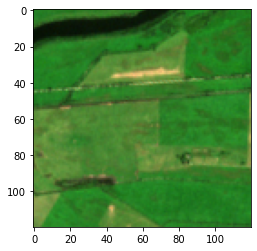

In [185]:
raster_B02 = rasterio.open("/origin/Models/TrainningDataset/BigEarthNet-v1.0/"+tile+"/"+tile+"_B02.tif")
raster_B03 = rasterio.open("/origin/Models/TrainningDataset/BigEarthNet-v1.0/"+tile+"/"+tile+"_B03.tif")
raster_B04 = rasterio.open("/origin/Models/TrainningDataset/BigEarthNet-v1.0/"+tile+"/"+tile+"_B04.tif")


b2 = raster_B02.read(1)
b3 = raster_B03.read(1)
b4 = raster_B04.read(1)

rgb = np.dstack([b4,b3,b2])

rgb = plot.adjust_band(rgb)
    
plt.imshow(rgb)

In [186]:
handle = open("/origin/Models/TrainningDataset/BigEarthNet-v1.0/"+tile+"/"+tile+"_labels_metadata.json", 'r')       
loaded_json = json.load(handle)
print(json.dumps(loaded_json, indent=4, sort_keys=False))
handle.close()

# To see the projection of the points in lat lon format check https://epsg.io/transform#s_srs=32634&t_srs=4326&x=544380.0000000&y=6114840.0000000

{
    "labels": [
        "Pastures",
        "Land principally occupied by agriculture, with significant areas of natural vegetation",
        "Water courses"
    ],
    "coordinates": {
        "ulx": 544380,
        "uly": 6114840,
        "lrx": 545580,
        "lry": 6113640
    },
    "projection": "PROJCS[\"WGS 84 / UTM zone 34N\",GEOGCS[\"WGS 84\",DATUM[\"WGS_1984\",SPHEROID[\"WGS 84\",6378137,298.257223563,AUTHORITY[\"EPSG\",\"7030\"]],AUTHORITY[\"EPSG\",\"6326\"]],PRIMEM[\"Greenwich\",0,AUTHORITY[\"EPSG\",\"8901\"]],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]],AXIS[\"Latitude\",NORTH],AXIS[\"Longitude\",EAST],AUTHORITY[\"EPSG\",\"4326\"]],PROJECTION[\"Transverse_Mercator\"],PARAMETER[\"latitude_of_origin\",0],PARAMETER[\"central_meridian\",21],PARAMETER[\"scale_factor\",0.9996],PARAMETER[\"false_easting\",500000],PARAMETER[\"false_northing\",0],UNIT[\"metre\",1,AUTHORITY[\"EPSG\",\"9001\"]],AXIS[\"Easting\",EAST],AXIS[\"Northing\",NORTH],AUTHORITY[\"EPSG\"

In [187]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph("/origin/Models/bigearthnet-models-tf/model_weights/original_labels/ResNet50/ResNet50_BigEarthNet_original_labels.meta")
    saver.restore(sess, "/origin/Models/bigearthnet-models-tf/model_weights/original_labels/ResNet50/ResNet50_BigEarthNet_original_labels")

INFO:tensorflow:Restoring parameters from /origin/Models/bigearthnet-models-tf/model_weights/original_labels/ResNet50/ResNet50_BigEarthNet_original_labels
